<a href="https://colab.research.google.com/github/shakhovak/Study-projects-in-Uni/blob/master/Reinforced_Learning_beginner/PONG_RL_HW2_FIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 2 Обучение на основе функции полезности

**Задача:** воспроизвести результаты DQN на двух играх Atari.

**Описание.** Ваша задача — воспроизвести результаты DQN на играх Pong и другой игре на ваш выбор из таблицы лекций или семинара. Важно, чтобы вы не выбрали игру, где результат человека значительно превосходит DQN. Учтите, что некоторые игры могут потребовать специфических методов, например, MontezumaRevenge.

Цель состоит в том, чтобы ваш агент достиг среднего вознаграждения, указанного в таблице для DQN, с учетом std dev.

**Детали:**
- Воспользуйтесь техниками из оригинальной статьи DeepMind: replay buffer, frame skip, target network.
- Можно использовать любой фреймворк.
- Приветствуются улучшения базового кода или дополнительные техники.

**Что нужно сдать:**
- Код обучения в формате Jupyter.
- График сходимости, показывающий среднее вознаграждение.
- Веса обученной модели.
- Код для запуска модели с готовыми весами.
- Выводы по используемым гиперпараметрам, таким как размер replay buffer, learning rate и т. д.

# План решения

В этом ноутбуке буду обучать агента играть в игру **Pong**. В решении будет несколько этапов:

1. Воспользуюсь некоторыми обертками для среды, чтобы можно было перерабатывать данные из среды в формат, приемлимый для нейронной сети. Здксь воспользуюсь стандартым подходом обработки фремов из игры, в точ числе frame skip, когда будет обрабытываться не один фрейм, а стек из 4-х фреймов.

2. Подготовлю 2 серточных сети, которые будут участвовать в обучении агента.

3. Буду также использовать буфер опыта (experience buffer)

Этот ноутбук включает как обучение, так и инференс модели уже с загруженными весами модели. Веса модели в этом же репозитории.

Обучение проходило на ВМ Yandex Cloud, используемая конфигруция включает V100. **ДЛя работы в Colab, нужно поменять значок % на ! при загрузке библиотек, в остальном все должно работать!**


In [1]:
#%apt-get update > /dev/null 2>&1
###!pip install --upgrade setuptools 2>&1
#!pip install ez_setup > /dev/null 2>&1
%pip install --upgrade gymnasium > /dev/null 2>&1
%pip install "gymnasium[atari, accept-rom-license]" > /dev/null 2>&1
%pip install -y swig > /dev/null 2>&1
%pip install gymnasium[box2d] > /dev/null 2>&1

In [3]:
%pip install moviepy --upgrade > /dev/null 2>&1

In [4]:
import cv2
import copy
import random
import gc
import gymnasium as gym
import numpy as np
import torch
import ipywidgets as widgets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from gym import spaces
from tqdm import tqdm
from collections import deque
from IPython import display
from IPython.display import clear_output
from matplotlib import animation
from torchsummary import summary
import warnings
warnings.filterwarnings("ignore")

import argparse
import time
import collections

cv2.ocl.setUseOpenCL(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Gym Wrappers

Воспользуюсь готовыми wrappers для atari games ([ссылка здесь](https://)(https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)) для модификации output для среды.

**Wrappers:**

- Обертки для кода OpenAI gym
- позволяют трансформировать наблюдения из среды для передачи в нейронную сеть и наоборот, из нейронной сети для передачи в среду

В этом решении я использовала следующие обертки:

- **MaxAndSkipEnv** - поволяет собирать в один стек 4 фрейма игры для обучения и принятия решения. В целом значительно ускоряет обучение агента. Для Pong - обязательно.
- **FireResetEnv** - позволяет автоматически нажимать кнопку удара, если это требуется в игре. Для pong - обязательна
- **ProcessFrame** - обрабатывает фреймы как картинки: переводит в черно-белый цвет, уменьшает размер для ускорения обучения
- **BufferWrapper** - отслеживает последние 4 фрейма и приводит их в формат тензора
- **ImageToPyTorch** - приводит тензоры в формат, необходимый для нейронной сети

Далее соединяем все обертки в один стек, который будет запускаться при перезапуске среды (на команду reset)


In [5]:
# for the atari games that require fire button
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, reward, done, truncated, info = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, reward, done, truncated, info = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs, info

    def step(self, action):
        return self.env.step(action)

# to increase the speed of learning by processing every 4th frame and return the frame with highest reward
# frame skipping
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)

        return max_frame, total_reward, done, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

# convert images to black&white and down-size images
class ProcessFrame(gym.ObservationWrapper):
    def __init__(self, env):
      super(ProcessFrame, self).__init__(env)
      self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame.process(obs)

    @staticmethod
    def process(frame):
        img = np.reshape(frame, frame.shape).astype(np.float32)
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


# pytorch requires tensors in a form {channel, width, height}, current data is in a form {width, height, channel}
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
      super(ImageToPyTorch, self).__init__(env)
      old_shape = self.observation_space.shape
      self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)
    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self, **kwargs):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        obs, info = self.env.reset(**kwargs)
        return self.observation(obs), info

    def observation(self, observation):
      self.buffer[:-1] = self.buffer[1:]
      self.buffer[-1] = observation
      return self.buffer

# normalizes pixels to tensor with values between 0 and 1
class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


# generate a stack of wrappers each time env is reset
def make_env(env_name):
    env = gym.make(env_name, render_mode = 'rgb_array')
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)

# Hyperparametres

Добавим гиперпараметры:
- **MEAN_REWARD_GOAL** - целевая среднее величина за 100 последних эпизода. При достижении этой величины закончится обучение агента. В задании нам предлагают воспользоваться величиной 18,9 (со стандартным отклонением в 1,3). Для того, чтобы этого добиться я буду рассчитывать среднее за 100 эпизодов и выберу величину 19,5. Думаю, таким образом, я смогу добиться нужного результата включая стандратное отклонение.
- **GAMMA** - фактор дисконтирования для уравнения Белмана, величина от 0 до 1. Чем ближе величина к нулю, тем меньший вес передается текущему вознаграждению, вынуждая агента откладывать вознаграждение на будущее. Для игры в понг, я взяла гамму == **0,99**, так  игра не долгая и нет необходимости придавать бОльший вес отложенным вознаграждениям.
- **BATCH_SIZE** - величина батча с данными, приходящего в нейронную сеть. Здесь основное ограничение - объем памяти. При обучении на T4 довольно быстро идет обучение с размеров батча == **32**. думаю, такой размер оптимален при выборе между скоростью обучения и его качеством.
- **REPLAY_BUFFER_SIZE** - максимальная вместимость буфера опыта. БОльшая величина буфера позволяет сохранять разнообразные варианты опыта, уменьшая таким образом потенциальную корреляцию и делая модель более устойчивой на инференсе. При этом слишком большой размер буфера может замедлить обучение. Для игры в Pong проводилось исследование [вот ссылка](https://github.com/rikluost/RL_DQN_Pong) как размер буфера влияет на среднюю величину вознаградения. Как видно из рисунка ниже - 50 тыс. оптимальное. Я решила взять **20 тыс**, так как есть опасения из-за ограничения ресурсов.

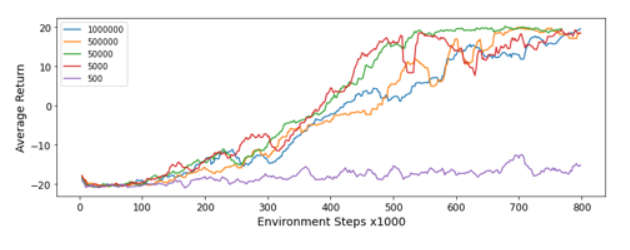


- **REPLAY_MIN_SIZE** минимальное количество перехов в буфере перед началом обратного распространения ошибки внутри сети. Я выбрала величину равную буферу в **10000**. Каких-то исследований про эту величину я не нашла, воспользовалась примером в нескольких имплементациях.
- **LEARNING_RATE = 1e-4**. Данную величину чаще всего используют в имплеметациях, получая хорошие результаты именно для игры понг.
- **SYNC_TARGET_FRAMES = 1000** - как часто веса из основной модели копируются в дублирующую для предсказания следующего состояния

- **EPSILON_START = 1.0** - начальная величина вероятности семплирования рандомного действия.
- **EPSILON_FINAL = 0.02** - минимальная величина вероятности семплирования рандомного действия
- **EPSILON_DECAY_FRAMES = 10^5** - количество шагов перехода от начальной величины вероятности к минимальной

Данный подход (часто называют жадной стратегией подбора параметра) позволяет уменьшатиь вероятность семплирования рандомнго действия, так как растет уверенность модели в предсказании (см. рисунок ниже). В большинтсве случаем начинают всегда с максимального значения в 1, когда только рандомное семплирование. Финальное значение 1-2% для вероятности для обеспечения рандомности. Также кол-во шагов часто берут именно 0,0005, так как модель успевает уже неплохо выучится за это время.


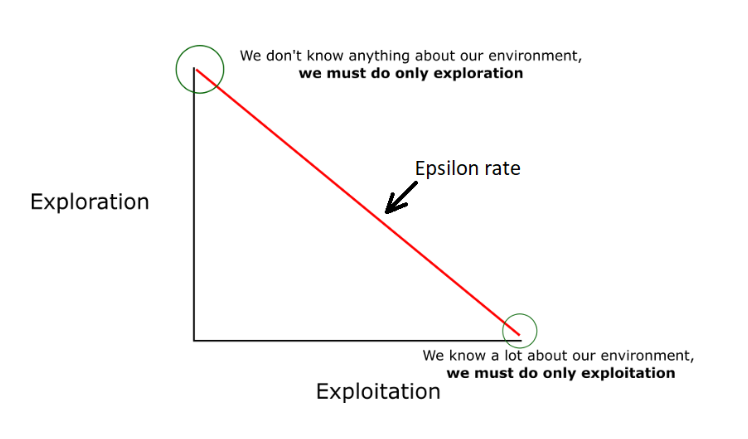

In [6]:
DEFAULT_ENV_NAME = "PongNoFrameskip-v4"
MEAN_REWARD_GOAL = 19.0 # when reward for the last 100 episodes exeeds this threshhold the training stops

GAMMA = 0.99 # discount factor
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 20000
REPLAY_MIN_SIZE = 10000 # min transitions before back propagation
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1000 # how often are weights are copied from main network to target network

EPSILON_START = 1.0
EPSILON_FINAL = 0.02
EPSILON_DECAY_FRAMES = 10**5


Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

Активируем среду и посмотрим основные параметры:

Action Space Discrete(6)
State Space Box(0.0, 1.0, (4, 84, 84), float32)


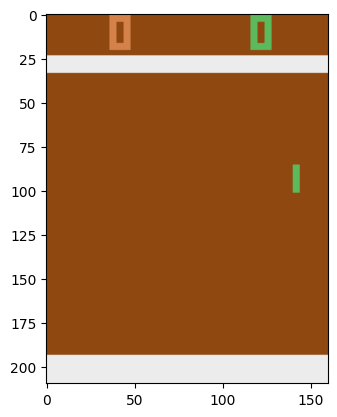

In [7]:
env = make_env(DEFAULT_ENV_NAME)
env.reset()
plt.imshow(env.render())

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Для обучения нейронной сети создается буфер для хранения опыта. В него добавляем 2 метода: добавления опыта в буфер (append) и семплирование из буфера (sample)

In [ ]:
# replay buffer
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, state, action, reward, done, new_state):
        state = np.expand_dims(state, 0)
        new_state = np.expand_dims(new_state, 0)
        self.buffer.append([state, action, reward, done, new_state])

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])

        return np.concatenate(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.concatenate(next_states)


Создаем класс агента, который будет обучаться игре. Основной метод агента - **play step** - здесь как раз используется жадный алгоритм, регулируемый величиной epsilon. Как я писала выше данная величина ответсвенна за рандомное семплирование действия или его получение из нейронное сети.

In [ ]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        state, _ = env.reset()
        self.state = state
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):
        done_reward = None

        if np.random.random() < epsilon:
           action = env.action_space.sample()

        else:

           state_a = np.array([self.state], copy=False)
           state_v = torch.tensor(state_a).to(device)
           q_vals_v = net(state_v)
           _, act_v = torch.max(q_vals_v, dim=1)
           action = int(act_v.item())

        # do step in the environment
        new_state, reward, is_done, _ , _ = self.env.step(action)
        self.total_reward += reward
        new_state = new_state

        state, action, reward, done, new_state = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(state, action, reward, done, new_state)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

## Функция для расчета loss
Для расчета loss используется батч из буфера,который подается в основную и вспомогательную сети. Все входящие данные из батча конвертируются в тензоры.
Текущее состояние подается в основную сеть, следующее состояние во вспомогательную. На основании полученных величин рассчитывается MSELoss. использование done для закончившихся эпизодов позволяет корректно рассчитать ошибку

In [ ]:
def calc_loss(batch_size, net, tgt_net, device="cpu"):
    #states, actions, rewards, dones, next_states = batch
    states, actions, rewards, dones, next_states = buffer.sample(batch_size)

    states_v = torch.tensor(states).to(device)
    next_states_v = torch.tensor(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done = torch.FloatTensor(dones).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    next_state_values = tgt_net(next_states_v).max(1)[0]

    next_state_values = next_state_values.detach()

    expected_state_action_values = GAMMA * next_state_values * (1-done) + rewards_v
    return nn.MSELoss()(state_action_values, expected_state_action_values)


In [ ]:
import os
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [ ]:
def plot(frame_idx, rewards, game):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.imshow(game)
    plt.show()

# Network architecture

В качестве основной модели буду использовать сверточную сеть, так как обучается агент на основе изображений, в которую включены следующие слои:

- **Input** (== 4 для Pong, так используется стек из 4-х фреймов)
- **Conv2D-> ReLU (x3)** - 3 слоя свертки
- **Fully Connected (512)** -> ReLU
- **Actions** (на выходе нам нужно одно из 5 действий, поэтому выход из сети будет вектор, равный 6)


In [8]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        #conv_out = torch.flatten(self.conv(x), start_dim=1 )
        return self.fc(conv_out)

In [ ]:
net = DQN(env.observation_space.shape, env.action_space.n).to(device)
tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)

In [ ]:
summary(net, env.observation_space.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
              ReLU-2           [-1, 32, 20, 20]               0
            Conv2d-3             [-1, 64, 9, 9]          32,832
              ReLU-4             [-1, 64, 9, 9]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
              ReLU-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 512]       1,606,144
              ReLU-9                  [-1, 512]               0
           Linear-10                    [-1, 6]           3,078
Total params: 1,687,206
Trainable params: 1,687,206
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.35
Params size (MB): 6.44
Estimat

# Training

Основной цикл обучения включает инициализацию буфера опыта и агента. Накопленное вознаграждение за игру буду собирать в total_rewards. По каждой игре буду выводить результаты.
При увеличении средней величины вознаграждения за послдение 100 эпизодов веса модели будут сохраняться в качестве лучшей. Обучение остановится, когда будет достигнут нужный уровень вознаграждения.

In [ ]:
buffer = ExperienceBuffer(REPLAY_BUFFER_SIZE)
agent = Agent(env, buffer)
epsilon = EPSILON_START

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
total_rewards = []
frame_idx = 0
ts_frame = 0
ts = time.time()
best_mean_reward = None

mkdir('.', 'checkpoints')

while True:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_FRAMES)

        reward = agent.play_step(net, epsilon, device=device)
        if reward is not None:
            total_rewards.append(reward)
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            mean_reward = np.mean(total_rewards[-100:])
            print("%d: done %d games, mean reward %.3f, eps %.2f, speed %.2f f/s" % (
                frame_idx, len(total_rewards), mean_reward, epsilon,
                speed
            ))

            if best_mean_reward is None or best_mean_reward < mean_reward:
                torch.save(net.state_dict(), './checkpoints/' + DEFAULT_ENV_NAME + "-best.dat")
                if best_mean_reward is not None:
                    print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
                best_mean_reward = mean_reward
            if mean_reward > MEAN_REWARD_GOAL:
                print("Solved in %d frames!" % frame_idx)
                break

        if len(buffer) < REPLAY_MIN_SIZE:
            continue

        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())

        optimizer.zero_grad()
        #batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(BATCH_SIZE, net, tgt_net, device=device)
        loss_t.backward()
        optimizer.step()


791: done 1 games, mean reward -21.000, eps 0.99, speed 539.59 f/s
1669: done 2 games, mean reward -21.000, eps 0.98, speed 569.70 f/s
2640: done 3 games, mean reward -21.000, eps 0.97, speed 581.13 f/s
3481: done 4 games, mean reward -21.000, eps 0.97, speed 586.70 f/s
4303: done 5 games, mean reward -21.000, eps 0.96, speed 582.78 f/s
5065: done 6 games, mean reward -21.000, eps 0.95, speed 583.94 f/s
6113: done 7 games, mean reward -20.714, eps 0.94, speed 571.84 f/s
Best mean reward updated -21.000 -> -20.714, model saved
6935: done 8 games, mean reward -20.750, eps 0.93, speed 562.45 f/s
7842: done 9 games, mean reward -20.778, eps 0.92, speed 578.96 f/s
8750: done 10 games, mean reward -20.800, eps 0.91, speed 569.80 f/s
9679: done 11 games, mean reward -20.727, eps 0.90, speed 572.52 f/s
10716: done 12 games, mean reward -20.667, eps 0.89, speed 134.42 f/s
Best mean reward updated -20.714 -> -20.667, model saved
11538: done 13 games, mean reward -20.692, eps 0.88, speed 107.40 f

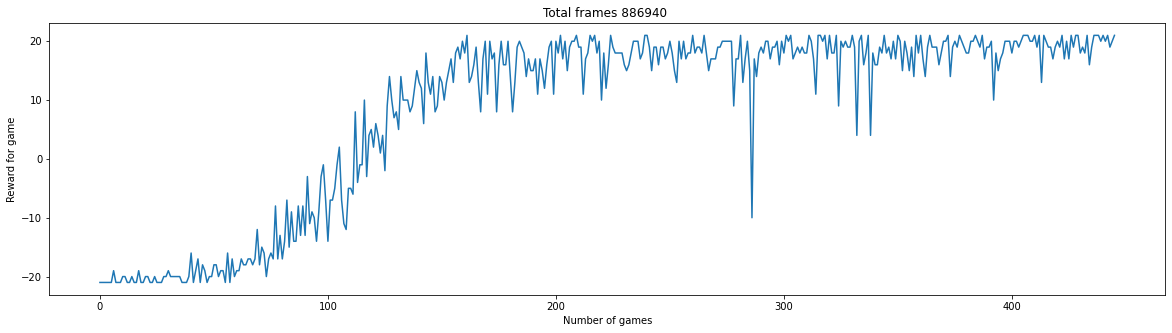

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(total_rewards)
plt.title('Total frames %s ' % (frame_idx))
plt.xlabel('Number of games')
plt.ylabel('Reward for game')
plt.show()

# Inference

Для инференса восполозуюсь оберткой от gym wrappers **RecordVideo**, которая позволяет записывать видео игры. Так как я в процессе обучения агента загружала веса лучшей модели в виде словаря, то я могу воспользоваться ими для инференса.

In [9]:
from gymnasium.wrappers.record_video import RecordVideo
env = RecordVideo(env, "./play_recording")

Модель нужно загрузить в директорию ноутбука для того, чтобы сработал код. Веса модели можно скачать вот здесь https://github.com/shakhovak/Study-projects-in-Uni/blob/master/Reinforced_Learning_beginner/PongNoFrameskip-v4-best.dat

In [11]:
model_path = 'PongNoFrameskip-v4-best.dat'
inference_net = DQN(env.observation_space.shape, env.action_space.n)
inference_net.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))

<All keys matched successfully>

In [12]:
FPS = 25
state, info = env.reset()
state = np.expand_dims(state, 0)
total_reward = 0.0
c = collections.Counter()

while True:
    start_ts = time.time()
    #env.render()
    state_v = torch.tensor(np.concatenate([state]))
    q_vals = inference_net(state_v).cpu().data.numpy()[0]
    action = np.argmax(q_vals)
    c[action] += 1
    state, reward, done, _ , _ = env.step(action)
    state = np.expand_dims(state, 0)
    total_reward += reward
    if done:
        break
    delta = 1/FPS - (time.time() - start_ts)
    if delta > 0:
          time.sleep(delta)
print("Total reward: %.2f" % total_reward)
print("Action counts:", c)
env.env.close()

Moviepy - Building video /content/play_recording/rl-video-episode-0.mp4.
Moviepy - Writing video /content/play_recording/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/play_recording/rl-video-episode-0.mp4
Total reward: 21.00
Action counts: Counter({5: 788, 0: 268, 4: 215, 1: 155, 2: 110, 3: 94})


Функция для просмотра видео:

In [13]:
import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

def show_video(folder="./play_recording"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [14]:
show_video()

# Выводы:

Агент довольно быстро научился играть в pong и полученная модель дает требуемые средние результаты.